У цьому ноутбуці ми розберемо явище мультиколінеарності, та способи протидії мультиколінеарності.

Мультиколінеарність можна побачити по кореляційній матриці даних (багато значень >0.9 )

Розберемо типові способи протидії мультиколінеарності:

1) відкидання зайвих ознак

2) регуляризація (регресії Ridge, Lasso)

3) перехід у новий простір ознак (метод головних компонент - PCA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

In [2]:
data = pd.read_csv("train.csv", index_col = 'id')
data.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [3]:
data['Weight2'] = 2.2 * data['Weight']

In [4]:
categorical = ['Sex']
target = 'Age'
numerical = data.columns.difference(categorical+[target]).tolist()

numerical

['Diameter',
 'Height',
 'Length',
 'Shell Weight',
 'Shucked Weight',
 'Viscera Weight',
 'Weight',
 'Weight2']

Outlier removal

In [5]:
for col in numerical:
    mean, std = data[col].mean(), data[col].std()
    data = data[(data[col]>=mean-3*std) & (data[col]<=mean+3*std) ]

<Axes: >

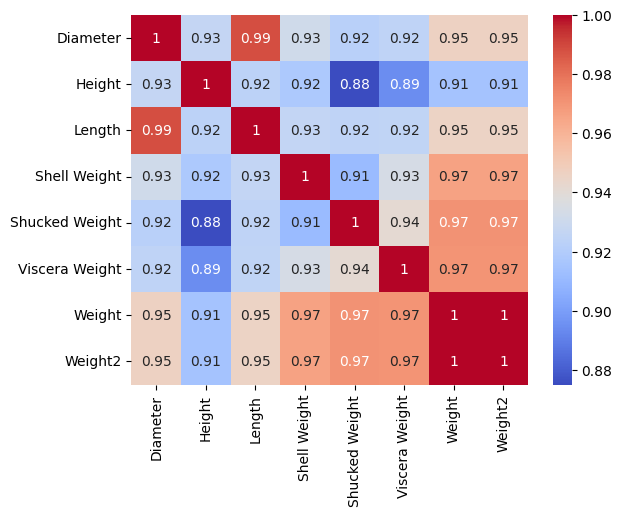

In [6]:
sns.heatmap(data[numerical].corr(), cmap = 'coolwarm', annot = True)

По матриці кореляцій можна бачити, що в даних висока мультиколінеарність (практично всі змінні корелюють одна із одною із $ r_{ij} >=0.9 $

In [7]:
data[numerical].corrwith(data[target]).sort_values(ascending=False)

Shell Weight      0.656651
Height            0.631618
Diameter          0.604809
Length            0.596143
Weight            0.592567
Weight2           0.592567
Viscera Weight    0.566489
Shucked Weight    0.491911
dtype: float64

### Чи впливає стандартизація на кореляцію в даних?

$$ X_{stded} = \cfrac{X - \mu}{\sigma} $$

In [8]:
## standartization
data_stded = data.copy()

for col in numerical:
    mean, std = data_stded[col].mean(), data_stded[col].std()
    data_stded[col] = (data_stded[col] - mean)/(std)

In [9]:
#спосіб зробити те саме, але через sklearn
"""
from sklearn.preprocessing import StandardScaler
std_scaler = StandartScaler()
data_stded_arr = std_scaler.fit_transform(data[numerical]) #тут отримуємо np.array із нормалізованими колонками
data_stded = pd.DataFrame(data_stded, columns = numerical) #повертаємо назви колонок

#категорійні колонки не змінюємо
for cat_col in categorical:
    data_stded[cat_col] = data[cat_col]
"""

'\nfrom sklearn.preprocessing import StandardScaler\nstd_scaler = StandartScaler()\ndata_stded_arr = std_scaler.fit_transform(data[numerical]) #тут отримуємо np.array із нормалізованими колонками\ndata_stded = pd.DataFrame(data_stded, columns = numerical) #повертаємо назви колонок\n\n#категорійні колонки не змінюємо\nfor cat_col in categorical:\n    data_stded[cat_col] = data[cat_col]\n'

### Дивимось, чи змінилася матриця кореляції при стандартизації даних

In [10]:
(data[numerical].corr() - data_stded[numerical].corr()).round(5)

,Diameter,Height,Length,Shell Weight,Shucked Weight,Viscera Weight,Weight,Weight2
Diameter,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
Height,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
Length,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
Shell Weight,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0
Shucked Weight,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
Viscera Weight,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
Weight,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0
Weight2,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0


### Чи змінюється кореляція даних при mix-max нормуванні?

$$ X_{normed} = \cfrac{X - X_{min}}{X_{max}-X_{min}} $$

In [11]:
## normalization
data_normed = data.copy()

for col in numerical:
    min_, max_ = data_normed[col].min(), data_normed[col].max()
    data_normed[col] = (data_normed[col] - min_)/(max_ - min_)

In [12]:
#спосіб зробити те саме, але через sklearn
"""
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
data_normed_arr = minmax_scaler.fit_transform(data[numerical]) #тут отримуємо np.array із нормалізованими колонками
data_normed = pd.DataFrame(data_normed, columns = numerical) #повертаємо назви колонок

#категорійні колонки не змінюємо
for cat_col in categorical:
    data_normed[cat_col] = data[cat_col]
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\nminmax_scaler = MinMaxScaler()\ndata_normed_arr = minmax_scaler.fit_transform(data[numerical]) #тут отримуємо np.array із нормалізованими колонками\ndata_normed = pd.DataFrame(data_normed, columns = numerical) #повертаємо назви колонок\n\n#категорійні колонки не змінюємо\nfor cat_col in categorical:\n    data_normed[cat_col] = data[cat_col]\n'

In [13]:
(data[numerical].corr() - data_normed[numerical].corr()).round(5)

,Diameter,Height,Length,Shell Weight,Shucked Weight,Viscera Weight,Weight,Weight2
Diameter,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
Height,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
Length,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
Shell Weight,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
Shucked Weight,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
Viscera Weight,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
Weight,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
Weight2,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0


Надалі в цьому ноутбуці, будемо вважати що ми вже привели дані до одної шкали і будемо в основному користуватись data_stded.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


X_train, X_test, y_train, y_test = train_test_split(data_stded[numerical], data_stded[target], test_size=0.2)

In [15]:
models_list = dict()
y_test_pred_list = dict()

Побудуємо типову модель лінійної регресії на всіх змінних, щоб далі нам було від чого відштовхуватись:

In [16]:
from sklearn.linear_model import LinearRegression

key = "lr_basic"

lr = LinearRegression(fit_intercept = True)
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)

models_list[key] = lr; y_test_pred_list[key] = y_test_pred

lr.intercept_, lr.coef_

(9.998586016662864,
 array([ 0.5266667 ,  0.78730813,  0.18481344,  1.95081612, -3.49997176,
        -0.56378598,  1.25883864,  1.25883864]))

In [17]:
r2_score(y_test, y_test_pred)

0.5398301425539878

### 1) Відкидання непотрібних змінних

Якщо знаходимо деяку пару змінних, яка корелює більше ніж 0.95, з двох залишаємо тільки одну

In [18]:
data[numerical].corr()

,Diameter,Height,Length,Shell Weight,Shucked Weight,Viscera Weight,Weight,Weight2
Diameter,1.000000,0.926574,0.988612,0.931290,0.922352,0.924601,0.946702,0.946702
Height,0.926574,1.000000,0.923362,0.917791,0.875032,0.894427,0.914686,0.914686
Length,0.988612,0.923362,1.000000,0.925976,0.924567,0.924911,0.945560,0.945560
Shell Weight,0.931290,0.917791,0.925976,1.000000,0.911086,0.933717,0.966062,0.966062
Shucked Weight,0.922352,0.875032,0.924567,0.911086,1.000000,0.941349,0.970946,0.970946
Viscera Weight,0.924601,0.894427,0.924911,0.933717,0.941349,1.000000,0.970412,0.970412
Weight,0.946702,0.914686,0.945560,0.966062,0.970946,0.970412,1.000000,1.000000
Weight2,0.946702,0.914686,0.945560,0.966062,0.970946,0.970412,1.000000,1.000000


In [19]:
relevant_cols = ["Diameter", 'Height', "Shell Weight", "Shucked Weight", 'Viscera Weight']
data[relevant_cols].corr()

,Diameter,Height,Shell Weight,Shucked Weight,Viscera Weight
Diameter,1.000000,0.926574,0.931290,0.922352,0.924601
Height,0.926574,1.000000,0.917791,0.875032,0.894427
Shell Weight,0.931290,0.917791,1.000000,0.911086,0.933717
Shucked Weight,0.922352,0.875032,0.911086,1.000000,0.941349
Viscera Weight,0.924601,0.894427,0.933717,0.941349,1.000000


In [20]:
from sklearn.linear_model import LinearRegression

key = "lr_cutted"

lr = LinearRegression(fit_intercept = True)
lr.fit(X_train[relevant_cols], y_train)

y_test_pred = lr.predict(X_test[relevant_cols])

models_list[key] = lr; y_test_pred_list[key] = y_test_pred

lr.intercept_, lr.coef_

(9.99825414901893,
 array([ 0.77369788,  0.81879596,  2.81360514, -2.51010935,  0.05626137]))

In [21]:
r2_score(y_test, y_test_pred)

0.5293088953397962

Видалення змінних може допомогти, може - і ні;

В даному випадку бачимо, що видалення змінних по взаємній колінеарності сильно не змінює ситуацію

### 2. Регуляризація

Альтернативами звичайній лінійній регресії є регуляризовані моделі Ridge і Lasso

LinearRegression: $ || X \beta - y ||^2 \rightarrow min_{\beta} $

Ridge: $ || X \beta - y ||^2 + \lambda \sum_{i=1}^n \beta_i^2 \rightarrow min_{\beta} $

Lasso: $ || X \beta - y ||^2 + \lambda \sum_{i=1}^n | \beta_i | \rightarrow min_{\beta} $

Змінюючи $ \lambda $ , можемо змінювати силу регуляризації

In [22]:
from sklearn.linear_model import Ridge, Lasso

for alpha in [1e-5, 1e-3, 1e0, 1e5, 1e10]:

    key = f"ridge_{alpha}"

    lr = Ridge(alpha = alpha, fit_intercept = True)
    lr.fit(X_train, y_train)

    y_test_pred = lr.predict(X_test)

    models_list[key] = lr; y_test_pred_list[key] = y_test_pred

    print(f"alpha = {alpha}, r2_score = {round(r2_score(y_test, y_test_pred), 5)}, coef = {lr.coef_.round(5)}")

alpha = 1e-05, r2_score = 0.53983, coef = [ 0.52667  0.78731  0.18481  1.95082 -3.49997 -0.56379  1.25884  1.25884]
alpha = 0.001, r2_score = 0.53983, coef = [ 0.52667  0.78731  0.18481  1.95082 -3.49997 -0.56379  1.25884  1.25884]
alpha = 1.0, r2_score = 0.53983, coef = [ 0.52655  0.78739  0.18484  1.95132 -3.49829 -0.56319  1.25749  1.25749]
alpha = 100000.0, r2_score = 0.38396, coef = [0.21942 0.28536 0.20487 0.31426 0.03477 0.15843 0.18679 0.18679]
alpha = 10000000000.0, r2_score = -0.00015, coef = [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]


In [23]:
from sklearn.linear_model import Ridge, Lasso

for alpha in [1e-4, 1e-2, 1e-1, 1e0, 1e2]:

    key = f"lasso_{alpha}"

    lr = Lasso(alpha = alpha, fit_intercept = True)
    lr.fit(X_train, y_train)

    y_test_pred = lr.predict(X_test)

    models_list[key] = lr; y_test_pred_list[key] = y_test_pred

    print(f"alpha = {alpha}, r2_score = {round(r2_score(y_test, y_test_pred), 5)}, coef = {lr.coef_.round(5)}")

alpha = 0.0001, r2_score = 0.53983, coef = [ 0.52678  0.78732  0.18386  1.95298 -3.49534 -0.56003  2.50812  0.     ]
alpha = 0.01, r2_score = 0.53772, coef = [ 0.53085  0.78737  0.09681  2.167   -3.03844 -0.19008  1.56707  0.     ]
alpha = 0.1, r2_score = 0.50033, coef = [ 0.       0.7596   0.       2.17594 -1.01231  0.       0.       0.     ]
alpha = 1.0, r2_score = 0.33558, coef = [0.      0.04239 0.      1.01198 0.      0.      0.      0.     ]
alpha = 100.0, r2_score = -0.00018, coef = [0. 0. 0. 0. 0. 0. 0. 0.]


Важливий коментар

Ridge ($L_2$ регуляризація) зменшує коефіцієнти перед змінними ЛАГІДНО - вони близькі до нуля, але ніколи не будуть в точності рівні нулю.

Lasso ($L_1$ регуляризація) зменшує коефіцієнти перед змінними ЖОРСТКО - деякі змінні мають нульову вагу, тому можна використовувати Lasso як один із способів відбору ознак.

Ця різниця пов'язана із природою функцій - квадрат координат є диференційовним, модуль координат - ні (не має похідної у точці 0)

### 3. Метод головних компонент

Головна ідея  - перейти у новий простір ознак, де ознаки будуть некорельовані між собою.

$$ (x_1, x_2, ... x_n) \longrightarrow (f_1, f_2, ..., f_m)  (m \leq n) $$
$$ corr (x_i, x_j) = r_{ij} \longrightarrow corr (f_i, f_j) = 0 $$

Фактично, це задача оптимізації, де кожна компонента намагається мати максимальну дисперсію (як раз із цієї причини метод називається ГОЛОВНИХ КОМПОНЕНТ):

$$ f_1 = a_1 x_1 + a_2 x_2 + ... + a_n x_n $$

$$ D f_1 \rightarrow max_{a_1, a_2, ... , a_n} $$

Будуємо наступну компоненту, але вона має бути перпендикулярна першій:

$$ f_2 = b_1 x_1 + b_2 x_2 + ... + b_n x_n $$

$$ D f_2 \rightarrow max_{b_1, b_2, ..., b_n} $$

$$ corr (f_1, f_2) = 0 $$

Будуємо третю компоненту (вона має бути перпендикулярною першим двом), і так далі:

$$ f_3 = c_1 x_1 + c_2 x_2 + ... + c_n x_n $$

$$ D f_3 \rightarrow max_{c_1, c_2, ..., c_n} $$

$$ corr (f_3, f_1) = 0 ; $$ 
$$ corr (f_3, f_2) = 0 $$

З точки зору лінійної алгебри - це задача пошуку діагональної форми коваріаційної матриці

$$ K = U J U^{-1} $$

K - вихідна матриця кореляцій, J - матриця кореляцій у новому просторі (вона буде діагональною і складатиметься із $ (D f_1, D f_2 , ... D f_n) $

n_components = 1, R^2 = 0.3785345869656259
n_components = 2, R^2 = 0.4292649776055212
n_components = 3, R^2 = 0.48032857431368614
n_components = 4, R^2 = 0.5292668978501024
n_components = 5, R^2 = 0.5299360450504922
n_components = 6, R^2 = 0.5398317578900318
n_components = 7, R^2 = 0.5398301425539878
n_components = 8, R^2 = 0.5398301425539878
Axes(0.125,0.11;0.62x0.77)


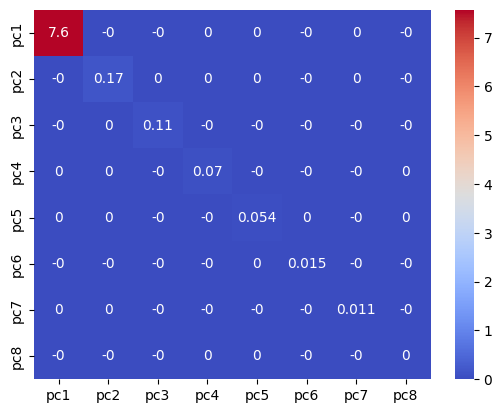

In [26]:
from sklearn.decomposition import PCA

#for n in [1,3,5,len(numerical)]:
for n in range(1, len(numerical)+1, 1):
    pca = PCA(n_components = n)
    
    X_train_pca = pd.DataFrame( pca.fit_transform(X_train), columns = [f'pc{i}' for i in range(1, n+1)] )
    
    lr = LinearRegression()
    lr.fit(X_train_pca, y_train)
    
    X_test_pca = pd.DataFrame( pca.transform(X_test), columns = [f'pc{i}' for i in range(1, n+1)] )
    
    y_test_pred = lr.predict(X_test_pca)
    
    print(f"n_components = {n}, R^2 = {r2_score(y_test, y_test_pred)}")
    
    if n==len(numerical):
        print(sns.heatmap(X_train_pca.cov().round(3), cmap='coolwarm', annot=True))
        #print(sns.heatmap(X_train_pca.corr().round(3), cmap='coolwarm', annot=True))

Можемо бачити і на практиці, що після застосування PCA матриця коваріацій є діагональною (перша компонента стягує на себе якомога більше дисперсії)

Застосування PCA унеможливлює мультиколінеарність в даних (нові змінні мають бути некорельованими між собою)